In [18]:
import spacy
import pandas as pd
from spacy import displacy
import matplotlib.pyplot as plt
#from spacy.pipeline import EntityRuler

In [19]:
NER = spacy.load("en_core_web_sm")
ruler = NER.add_pipe("entity_ruler", before='ner')

entities = ['rebels', 'rebel', 'Rebel', 'Rebels', 'dinka', 'Dinka', 'army', 'Army', 'Janjaweed', 'janjaweed', 'Messeriya', 'messeriya','peacekeepers', 
            'Peacekeepers', 'Darfurian traders', 'UNMISS', 'Government of the Republic of South Sudan', 'Darfuris','SSLM', 'SPLM', 'Machar', "Sudan People's Liberation Movement", 'SPLA']
locations = ['Juba', 'Bentiu', 'Unity State', 'Mayom', 'Bor', 'Jonglei', 'Malakal','Wau']

for i in entities:
        ruler.add_patterns([{"label": "ORG", "pattern": i}])
for l in locations:
        ruler.add_patterns([{"label": "GPE", "pattern": l}])

NER.pipeline

c:\Users\pthie\anaconda3\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1f19ad75430>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1f19ad75b50>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x1f19ac74d60>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1f19af49990>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1f19af4a590>),
 ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler at 0x1f19ac04990>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1f19ac74f90>)]

In [20]:
df = pd.read_csv('data/articles_topics_conflict_cleaned.csv', parse_dates=['date'])

# use for Article Assignment investigation

In [21]:
index = 3


tex = df['summary'][index]

display(df.iloc[index,:][['chat_GPT_location', 'cd_district_name']])

text1 = NER(tex)

orgs_dict = {}
1
for word in text1.ents:
    if word.label_ == 'ORG':
        org_name = word.text
        if org_name in orgs_dict:
            orgs_dict[org_name] += 1
        else:
            orgs_dict[org_name] = 1

# Display the organizations and their respective counts
print(f"Organizations mentioned in the article:\n")
for org, count in orgs_dict.items():
    print(f"{org}: {count}")

displacy.render(text1,style="ent",jupyter=True)

chat_GPT_location    Koch county
cd_district_name            Koch
Name: 3, dtype: object

Organizations mentioned in the article:

rebel: 3
Pakur: 1
army: 1
the Sudan People's Liberation: 1
Army: 1
SPLA: 5
Unity: 1


# FInding Articles explicitly mention Liberation Movement

In [22]:
looking_for = ['SPLM', 'SSLM', "Sudan People's Liberation Movement"]

articles_found = []

for index, content in df.iterrows():
    text1 = NER(content['summary'])
    for word in text1.ents:
        if word.label_ == 'ORG':
            org_name = word.text
            if org_name in looking_for:
                articles_found.append(index)
                break

print(f'total number of articles with matches: {len(articles_found)}')
print(f'Index of articles with matches: {articles_found}')

total number of articles with matches: 40
Index of articles with matches: [16, 21, 22, 71, 86, 93, 99, 108, 128, 132, 137, 152, 158, 170, 190, 199, 203, 220, 226, 244, 261, 276, 277, 280, 292, 295, 315, 318, 341, 342, 344, 345, 346, 347, 358, 363, 370, 376, 379, 457]


# Adding hand labeled info back into dataset (articles_handlabledd_v2_cleaned.csv)

In [23]:
df = pd.read_csv('data/article_handlabeled_v2_raw.csv')
df2 = pd.read_csv('data/articles_topics_conflict_cleaned.csv', parse_dates=['date'])
merged_df = df2.merge(df, left_index=True, right_on='Article index')
merged_df = merged_df.drop(['Article index', 'Location correct'], axis=1).rename({'keep location':'County level','hunger':'hunger_bert','refugees':'refugees_bert','humanitarian':'humanitarian_bert','conflict':'conflict_bert' }, axis=1)
merged_df = merged_df[(merged_df['County level'] == 'yes') | (merged_df['Unity level'] == 'yes')] # gets rid of any mislocated articles


merged_df['location_final'] = merged_df.apply(lambda row: row['cd_district_name'] if row['County level']=='yes' else 'Unity state', axis=1)

merged_df['location_final'].unique()




array(['Koch', 'Rubkona', 'Unity state'], dtype=object)

In [24]:
# # Count the occurrences of each unique value in 'location_final'
# location_counts = merged_df['location_final'].value_counts()

# display(location_counts)

# violence_counts = merged_df['Conflict'].value_counts()

# display(violence_counts)

# conflict_df = merged_df[merged_df['Conflict'] > 0]

# location_counts = conflict_df['location_final'].value_counts()

# display(location_counts)

# violence_counts = conflict_df['Conflict'].value_counts()

# display(violence_counts)

# mov_SS_counts = conflict_df['South Sudan / Liberation movement Conflict'].value_counts()

# display(mov_SS_counts)

In [25]:
merged_df.to_csv('data/articles_handlabeled_v2_cleaned.csv', index=False)

# Creating merged_df_for_causality.csv

In [26]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv('data/articles_handlabeled_v2_cleaned.csv', parse_dates=['date'])
df_conflict = df[df['Conflict'] > 0]
df_conflict = df_conflict[df['location_final'] == 'Rubkona']

df_conflict['date'] = df_conflict['date'].dt.to_period('M').dt.to_timestamp() # change to monthly date

# Group by 'date' and 'Conflict' rating and count the number of articles
grouped = df_conflict.groupby(['date', 'Conflict', 'location_final']).size().reset_index(name='Count')

# Pivot the table to have ratings as columns
pivot_table = grouped.pivot(index=['date','location_final'], columns='Conflict', values='Count').fillna(0)
# Reset index to have 'date' as a regular column
pivot_table.reset_index(inplace=True)


pivot_table = pivot_table.rename({1:'conflict_1#', 2:'conflict_2#'}, axis=1)
pivot_table['total_conflict#'] = pivot_table['conflict_1#'] + pivot_table['conflict_2#']

pivot_table

C:\Users\pthie\AppData\Local\Temp\ipykernel_17936\3689765157.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_conflict = df_conflict[df['location_final'] == 'Rubkona']


Conflict,date,location_final,conflict_1#,conflict_2#,total_conflict#
0,2011-07-01,Rubkona,0.0,1.0,1.0
1,2011-11-01,Rubkona,1.0,1.0,2.0
2,2012-03-01,Rubkona,0.0,2.0,2.0
3,2012-04-01,Rubkona,0.0,5.0,5.0
4,2013-03-01,Rubkona,1.0,0.0,1.0
5,2013-10-01,Rubkona,2.0,0.0,2.0
6,2013-11-01,Rubkona,0.0,2.0,2.0
7,2013-12-01,Rubkona,9.0,3.0,12.0
8,2014-01-01,Rubkona,11.0,2.0,13.0
9,2014-03-01,Rubkona,1.0,0.0,1.0


In [28]:
ipc_scores_df = pd.read_csv('data/food_crises_cleaned.csv', parse_dates=['date'])
# ipc_scores_df.dropna(subset=['ipc'], inplace=True)

ipc_scores_df = ipc_scores_df[(ipc_scores_df.district == 'Rubkona')]

min(ipc_scores_df['date'])
ipc_scores_df

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date
10902,South Sudan,143,Rubkona,29.63566,9.268476,2007_01,2007,1,NaN,NaN,...,0.101064,0,0,0.586252,3578.829,21.51323,107390.8,5674.409,88.27273,2007-01-01
10903,South Sudan,143,Rubkona,29.63566,9.268476,2007_02,2007,2,NaN,NaN,...,-0.027722,0,0,0.577403,3578.829,21.51323,107390.8,5674.409,88.27273,2007-02-01
10904,South Sudan,143,Rubkona,29.63566,9.268476,2007_03,2007,3,NaN,NaN,...,-0.186452,0,0,0.570951,3578.829,21.51323,107390.8,5674.409,88.27273,2007-03-01
10905,South Sudan,143,Rubkona,29.63566,9.268476,2007_04,2007,4,NaN,NaN,...,0.203491,0,0,0.593205,3578.829,21.51323,107390.8,5674.409,88.27273,2007-04-01
10906,South Sudan,143,Rubkona,29.63566,9.268476,2007_05,2007,5,NaN,NaN,...,-2.555527,0,0,0.609532,3578.829,21.51323,107390.8,5674.409,88.27273,2007-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11055,South Sudan,143,Rubkona,29.63566,9.268476,2019_10,2019,10,3.0,1.0,...,10.126940,1,0,73.311500,3578.829,21.51323,136305.0,5674.409,88.27273,2019-10-01
11056,South Sudan,143,Rubkona,29.63566,9.268476,2019_11,2019,11,NaN,NaN,...,10.113030,2,2,77.427860,3578.829,21.51323,136305.0,5674.409,88.27273,2019-11-01
11057,South Sudan,143,Rubkona,29.63566,9.268476,2019_12,2019,12,NaN,NaN,...,0.191347,0,0,81.231200,3578.829,21.51323,136305.0,5674.409,88.27273,2019-12-01
11058,South Sudan,143,Rubkona,29.63566,9.268476,2020_01,2020,1,NaN,NaN,...,0.347117,0,0,76.248710,3578.829,21.51323,139635.7,5674.409,88.27273,2020-01-01


In [29]:
# Generate a date range from '2012-01-01' to '2020-04-01' with a frequency of 1 month
date_range = pd.date_range(start='2007-01-01', end='2020-02-01', freq='MS')
# Create a DataFrame with a single column 'Date'
df_dates = pd.DataFrame({'Date': date_range})


# Display the DataFrame
df_dates = df_dates.merge(ipc_scores_df, left_on='Date', right_on='date', how='left')
df_dates = df_dates.merge(pivot_table, left_on=['Date','district'], right_on=['date','location_final'], how='left')
df_dates = df_dates.drop(['date_x', 'date_y', 'location_final'], axis =1)


df_dates['total_conflict#'].fillna(0, inplace=True)
df_dates['conflict_2#'].fillna(0, inplace=True)
df_dates['conflict_1#'].fillna(0, inplace=True)

df_dates

,Date,country,district_code,district,centx,centy,year_month,year,month,ipc,...,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,conflict_1#,conflict_2#,total_conflict#
0,2007-01-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_01,2007,1,NaN,...,0,0.586252,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
1,2007-02-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_02,2007,2,NaN,...,0,0.577403,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
2,2007-03-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_03,2007,3,NaN,...,0,0.570951,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
3,2007-04-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_04,2007,4,NaN,...,0,0.593205,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
4,2007-05-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_05,2007,5,NaN,...,0,0.609532,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2019-10-01,South Sudan,143,Rubkona,29.63566,9.268476,2019_10,2019,10,3.0,...,0,73.311500,3578.829,21.51323,136305.0,5674.409,88.27273,0.0,0.0,0.0
154,2019-11-01,South Sudan,143,Rubkona,29.63566,9.268476,2019_11,2019,11,NaN,...,2,77.427860,3578.829,21.51323,136305.0,5674.409,88.27273,0.0,0.0,0.0
155,2019-12-01,South Sudan,143,Rubkona,29.63566,9.268476,2019_12,2019,12,NaN,...,0,81.231200,3578.829,21.51323,136305.0,5674.409,88.27273,0.0,0.0,0.0
156,2020-01-01,South Sudan,143,Rubkona,29.63566,9.268476,2020_01,2020,1,NaN,...,0,76.248710,3578.829,21.51323,139635.7,5674.409,88.27273,0.0,0.0,0.0


In [30]:
df_dates.to_csv('data/merged_df_for_causality.csv', index = False)

# Creating merged_df_for_causality_v2.csv

In [31]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv('data/articles_handlabeled_v2_cleaned.csv', parse_dates=['date'])
df_conflict = df[df['Conflict'] >= 0]
df_conflict = df_conflict[df['location_final'] != 'Unity State']

df_conflict['Conflict'].value_counts()


2    175
1    115
0     16
Name: Conflict, dtype: int64

In [33]:
df = pd.read_csv('data/articles_handlabeled_v2_cleaned.csv', parse_dates=['date'])
df_conflict = df[df['Conflict'] > 0]
df_conflict = df_conflict[df['location_final'] != 'Unity State']

df_conflict['date'] = df_conflict['date'].dt.to_period('M').dt.to_timestamp() # change to monthly date

# Group by 'date' and 'Conflict' rating and count the number of articles
grouped = df_conflict.groupby(['date', 'Conflict', 'location_final']).size().reset_index(name='Count')

# Pivot the table to have ratings as columns
pivot_table = grouped.pivot(index=['date','location_final'], columns='Conflict', values='Count').fillna(0)
# Reset index to have 'date' as a regular column
pivot_table.reset_index(inplace=True)


pivot_table = pivot_table.rename({1:'conflict_1#', 2:'conflict_2#'}, axis=1)
pivot_table['total_conflict#'] = pivot_table['conflict_1#'] + pivot_table['conflict_2#']

pivot_table

C:\Users\pthie\AppData\Local\Temp\ipykernel_17936\2876824167.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_conflict = df_conflict[df['location_final'] != 'Unity State']


Conflict,date,location_final,conflict_1#,conflict_2#,total_conflict#
0,2011-07-01,Koch,0.0,2.0,2.0
1,2011-07-01,Rubkona,0.0,1.0,1.0
2,2011-08-01,Koch,0.0,1.0,1.0
3,2011-08-01,Unity state,0.0,1.0,1.0
4,2011-10-01,Unity state,2.0,0.0,2.0
...,...,...,...,...,...
74,2018-08-01,Unity state,0.0,1.0,1.0
75,2019-03-01,Rubkona,0.0,1.0,1.0
76,2019-03-01,Unity state,1.0,0.0,1.0
77,2022-09-01,Unity state,1.0,1.0,2.0


In [34]:
ipc_scores_df = pd.read_csv('data/food_crises_cleaned.csv', parse_dates=['date'])
# ipc_scores_df.dropna(subset=['ipc'], inplace=True)

ipc_scores_df = ipc_scores_df[(ipc_scores_df.district == 'Rubkona') | (ipc_scores_df.district == 'Koch')]

min(ipc_scores_df['date'])
ipc_scores_df

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date
8374,South Sudan,127,Koch,29.85742,8.633903,2007_01,2007,1,NaN,NaN,...,0.388964,0,0,0.604193,4428.075,10.10188,80686.66,5726.711,82.94444,2007-01-01
8375,South Sudan,127,Koch,29.85742,8.633903,2007_02,2007,2,NaN,NaN,...,-0.030209,0,0,0.585973,4428.075,10.10188,80686.66,5726.711,82.94444,2007-02-01
8376,South Sudan,127,Koch,29.85742,8.633903,2007_03,2007,3,NaN,NaN,...,-0.350389,0,0,0.591194,4428.075,10.10188,80686.66,5726.711,82.94444,2007-03-01
8377,South Sudan,127,Koch,29.85742,8.633903,2007_04,2007,4,NaN,NaN,...,0.593922,0,0,0.616998,4428.075,10.10188,80686.66,5726.711,82.94444,2007-04-01
8378,South Sudan,127,Koch,29.85742,8.633903,2007_05,2007,5,NaN,NaN,...,-3.411473,0,0,0.639228,4428.075,10.10188,80686.66,5726.711,82.94444,2007-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11055,South Sudan,143,Rubkona,29.63566,9.268476,2019_10,2019,10,3.0,1.0,...,10.126940,1,0,73.311500,3578.829,21.51323,136305.00,5674.409,88.27273,2019-10-01
11056,South Sudan,143,Rubkona,29.63566,9.268476,2019_11,2019,11,NaN,NaN,...,10.113030,2,2,77.427860,3578.829,21.51323,136305.00,5674.409,88.27273,2019-11-01
11057,South Sudan,143,Rubkona,29.63566,9.268476,2019_12,2019,12,NaN,NaN,...,0.191347,0,0,81.231200,3578.829,21.51323,136305.00,5674.409,88.27273,2019-12-01
11058,South Sudan,143,Rubkona,29.63566,9.268476,2020_01,2020,1,NaN,NaN,...,0.347117,0,0,76.248710,3578.829,21.51323,139635.70,5674.409,88.27273,2020-01-01


In [35]:
# Generate a date range from '2012-01-01' to '2020-04-01' with a frequency of 1 month
date_range = pd.date_range(start='2007-01-01', end='2020-02-01', freq='MS')
# Create a DataFrame with a single column 'Date'
df_dates = pd.DataFrame({'Date': date_range})


# Display the DataFrame
df_dates = df_dates.merge(ipc_scores_df, left_on='Date', right_on='date', how='left')
df_dates = df_dates.merge(pivot_table, left_on=['Date','district'], right_on=['date','location_final'], how='left')
df_dates = df_dates.drop(['date_x', 'date_y', 'location_final'], axis =1)


df_dates['total_conflict#'].fillna(0, inplace=True)
df_dates['conflict_2#'].fillna(0, inplace=True)
df_dates['conflict_1#'].fillna(0, inplace=True)
df_dates

,Date,country,district_code,district,centx,centy,year_month,year,month,ipc,...,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,conflict_1#,conflict_2#,total_conflict#
0,2007-01-01,South Sudan,127,Koch,29.85742,8.633903,2007_01,2007,1,NaN,...,0,0.604193,4428.075,10.10188,80686.66,5726.711,82.94444,0.0,0.0,0.0
1,2007-01-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_01,2007,1,NaN,...,0,0.586252,3578.829,21.51323,107390.80,5674.409,88.27273,0.0,0.0,0.0
2,2007-02-01,South Sudan,127,Koch,29.85742,8.633903,2007_02,2007,2,NaN,...,0,0.585973,4428.075,10.10188,80686.66,5726.711,82.94444,0.0,0.0,0.0
3,2007-02-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_02,2007,2,NaN,...,0,0.577403,3578.829,21.51323,107390.80,5674.409,88.27273,0.0,0.0,0.0
4,2007-03-01,South Sudan,127,Koch,29.85742,8.633903,2007_03,2007,3,NaN,...,0,0.591194,4428.075,10.10188,80686.66,5726.711,82.94444,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2019-12-01,South Sudan,143,Rubkona,29.63566,9.268476,2019_12,2019,12,NaN,...,0,81.231200,3578.829,21.51323,136305.00,5674.409,88.27273,0.0,0.0,0.0
312,2020-01-01,South Sudan,127,Koch,29.85742,8.633903,2020_01,2020,1,NaN,...,0,79.648870,4428.075,10.10188,104519.50,5726.711,82.94444,0.0,0.0,0.0
313,2020-01-01,South Sudan,143,Rubkona,29.63566,9.268476,2020_01,2020,1,NaN,...,0,76.248710,3578.829,21.51323,139635.70,5674.409,88.27273,0.0,0.0,0.0
314,2020-02-01,South Sudan,127,Koch,29.85742,8.633903,2020_02,2020,2,3.0,...,0,81.291000,4428.075,10.10188,104519.50,5726.711,82.94444,0.0,0.0,0.0


In [36]:
df_dates.to_csv('data/merged_df_for_causality_v2.csv', index = False)

# Plots for Rubkona

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df_dates = pd.read_csv('data/merged_df_for_causality.csv', parse_dates=['Date'])
df_dates

,Date,country,district_code,district,centx,centy,year_month,year,month,ipc,...,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,conflict_1#,conflict_2#,total_conflict#
0,2007-01-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_01,2007,1,NaN,...,0,0.586252,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
1,2007-02-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_02,2007,2,NaN,...,0,0.577403,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
2,2007-03-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_03,2007,3,NaN,...,0,0.570951,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
3,2007-04-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_04,2007,4,NaN,...,0,0.593205,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
4,2007-05-01,South Sudan,143,Rubkona,29.63566,9.268476,2007_05,2007,5,NaN,...,0,0.609532,3578.829,21.51323,107390.8,5674.409,88.27273,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2019-10-01,South Sudan,143,Rubkona,29.63566,9.268476,2019_10,2019,10,3.0,...,0,73.311500,3578.829,21.51323,136305.0,5674.409,88.27273,0.0,0.0,0.0
154,2019-11-01,South Sudan,143,Rubkona,29.63566,9.268476,2019_11,2019,11,NaN,...,2,77.427860,3578.829,21.51323,136305.0,5674.409,88.27273,0.0,0.0,0.0
155,2019-12-01,South Sudan,143,Rubkona,29.63566,9.268476,2019_12,2019,12,NaN,...,0,81.231200,3578.829,21.51323,136305.0,5674.409,88.27273,0.0,0.0,0.0
156,2020-01-01,South Sudan,143,Rubkona,29.63566,9.268476,2020_01,2020,1,NaN,...,0,76.248710,3578.829,21.51323,139635.7,5674.409,88.27273,0.0,0.0,0.0


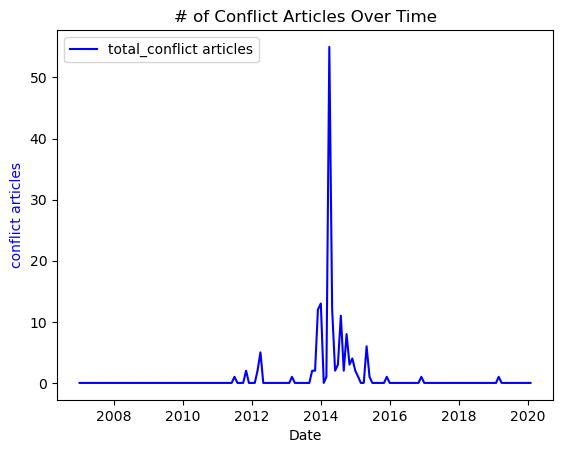

In [7]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot IPC data on the axis
ax.plot(df_dates['Date'], df_dates['total_conflict#'], color='b', label='total_conflict articles')
ax.set_xlabel('Date')
ax.set_ylabel('conflict articles', color='b')

# Customize the plot as needed
ax.set_title('# of Conflict Articles Over Time')
ax.legend(loc='upper left')

# Show the plot
plt.show()

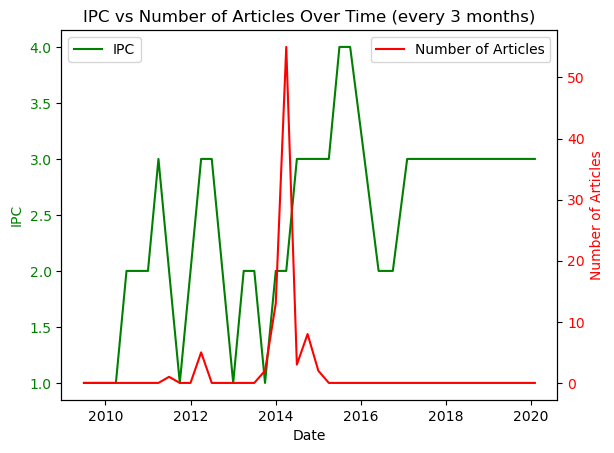

In [8]:
# Filter IPC data to include only values above 0
df_filtered = df_dates[df_dates['ipc'] > 0]

# Create a figure and axes
fig, ax1 = plt.subplots()

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot IPC data on the first axis (left y-axis)
ax1.plot(df_filtered['Date'], df_filtered['ipc'], color='g', label='IPC')
ax1.set_xlabel('Date')
ax1.set_ylabel('IPC', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Plot Number of Articles data on the second axis (right y-axis)
ax2.plot(df_filtered['Date'], df_filtered['total_conflict#'], color='r', label='Number of Articles')
ax2.set_ylabel('Number of Articles', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.set_title('IPC vs Number of Articles Over Time (every 3 months)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

       ipc  year  month district
10902  NaN  2007      1  Rubkona
10903  NaN  2007      2  Rubkona
10904  NaN  2007      3  Rubkona
10905  NaN  2007      4  Rubkona
10906  NaN  2007      5  Rubkona
...    ...   ...    ...      ...
11055  3.0  2019     10  Rubkona
11056  NaN  2019     11  Rubkona
11057  NaN  2019     12  Rubkona
11058  NaN  2020      1  Rubkona
11059  3.0  2020      2  Rubkona

[158 rows x 4 columns]


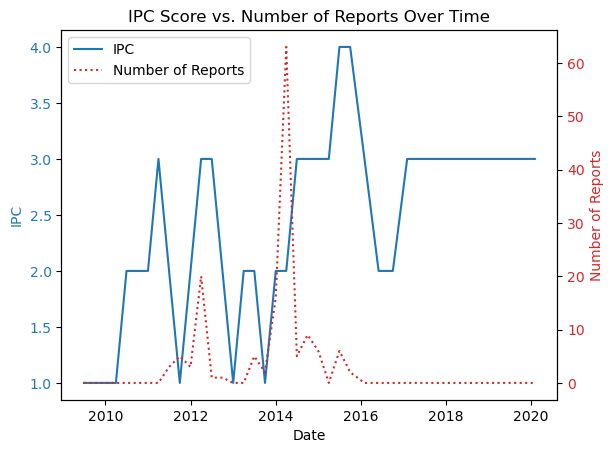

In [9]:
food = pd.read_csv("data/food_crises_cleaned.csv")
food = food[['ipc','year','month','district']]
food = food[food['district'] == 'Rubkona']
articles = pd.read_csv("data/articles_handlabeled_v2_cleaned.csv")

print(food)

import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'year' and 'month' columns to datetime format in the 'food' DataFrame
food['Date'] = pd.to_datetime(food['year'].astype(str) + '-' + food['month'].astype(str) + '-01')
food.dropna(subset=['ipc'], inplace=True)

# Convert the 'date' column to datetime format in the 'articles' DataFrame
articles['Date'] = pd.to_datetime(articles['date'])

# Set 'Date' as the index for both dataframes
food.set_index('Date', inplace=True)
articles.set_index('Date', inplace=True)

# Extract year and month from the 'Date' column in 'articles'
articles['Year'] = articles.index.year
articles['Month'] = articles.index.month

# Manually count the number of articles for each month
articles_count = articles.groupby(['Year', 'Month']).size().reset_index(name='Number_of_Reports')

# Calculate the average IPC score for each month
average_ipc = food.groupby(['year', 'month'])['ipc'].mean().reset_index(name='IPC')  # Rename to 'IPC' here

# Merge the two datasets based on the common 'Year' and 'Month' columns
merged_data = pd.merge(average_ipc, articles_count, left_on=['year', 'month'], right_on=['Year', 'Month'], how='left')

# Create a datetime column for the 'Date' index
merged_data['Date'] = pd.to_datetime(merged_data['year'].astype(str) + '-' + merged_data['month'].astype(str) + '-01')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Fill missing values in 'Number_of_Reports' with 0
merged_data['Number_of_Reports'].fillna(0, inplace=True)

fig, ax1 = plt.subplots()

# Left Y axis: IPC scores and Average IPC as line plots
ax1.set_xlabel('Date')
ax1.set_ylabel('IPC', color='tab:blue')

# Plot the IPC line without filling the area underneath
ipc_line = ax1.plot(merged_data.index, merged_data['IPC'], color='tab:blue', linestyle='-', label='IPC')  # Update label to 'IPC'

ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second Y axis on the right for Number of reports/articles
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Reports', color='tab:red')

# Create a continuously dotted line for Number of Reports
reports_line = ax2.plot(merged_data.index, merged_data['Number_of_Reports'], color='tab:red', linestyle=':', label='Number of Reports')  # Add label here

ax2.tick_params(axis='y', labelcolor='tab:red')

# Set x-axis label
ax1.set_xlabel('Date')

# Display the legend with both lines and labels
lines = ipc_line + reports_line  # Include both lines in the legend
labels = [line.get_label() for line in lines]  # Get labels for both lines
ax1.legend(lines, labels, loc='upper left')

# Display the plot
plt.title('IPC Score vs. Number of Reports Over Time')
plt.show()


## example for NER

In [10]:
orgs_dict = {}

for word in text1.ents:
    if word.label_ == 'ORG':
        org_name = word.text
        if org_name in orgs_dict:
            orgs_dict[org_name] += 1
        else:
            orgs_dict[org_name] = 1

# Display the organizations and their respective counts
print(f"Organizations mentioned in the article:\n")
for org, count in orgs_dict.items():
    print(f"{org}: {count}")


NameError: name 'text1' is not defined

In [ ]:
orgs = set()

for word in text1.ents:
    if word.label_ == 'ORG':
        orgs.add(word.text)

display(f'Orgs mentioned in article: {orgs}')

"Orgs mentioned in article: {'Justice', 'SSHURSA', 'the South Sudan Human Rights Society', 'the South Sudan National Legislative Assembly'}"

In [ ]:
# source: https://www.analyticsvidhya.com/blog/2021/06/nlp-application-named-entity-recognition-ner-in-python-with-spacy/
display(spacy.explain("ORG"))
display(spacy.explain("GPE"))
display(spacy.explain("LOC"))
displacy.render(text1,style="ent",jupyter=True)

'Companies, agencies, institutions, etc.'

'Countries, cities, states'

'Non-GPE locations, mountain ranges, bodies of water'